<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Mushroom Image Classification</b><br>
    <br>
</p>

<p style="text-align: right;">Module 4: Deep Learning<br>
Sprint 1: Computer Vision<br>
Author : Renato Mariano</p>

<img src="personal_images/cut_mushroom.jpg" width=350>
<div style="font-size: 1.0em;"> Source: Personal Archive </div>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the first Project of the Deep Learning Module! In this sprint, we embark on an exciting journey to develop **a classification model to predict mushroom common genuses**, leveraging the power of data science and convolutional neural networks.

**Background**

In the United States, approximately 7,500 cases of mushroom poisoning are reported annually, with the most common cause being misidentification of edible mushroom species. This issue is preventable through education.

**Project Context**

The objective of this project is to create a model that will classify mushrooms in their correct genus. This project leverages transfer learning and the exploration of different deep learning setups and network configurations. The dataset can be obtain on kaggle (https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images).

<h2 style="color:#774CAD">Library Imports</h2>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights, mobilenet_v2
from torchsummary import summary

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
import sys, importlib
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import imagehash

from model_functions import train_model
from dataset_loader import dataset_separation_loader
from model_evaluation import plot_loss, plot_confusion_matrix, evaluate_model, evaluate_model_on_test

# import warnings
# warnings.filterwarnings('ignore')
%load_ext blackcellmagic
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#774CAD">Model Definition</h1>

Here we keep the work started on the EDA part. The EDA part was improved after the presentation for the peer. After that, I ran only the first model try again to see how the results would change. I will expose for the first model, only the current results, but I will compare everything textually.

Let's first **load a dataframe with the path** for our images and **drop the bad and duplicated images**.

In [2]:
bad_images_idx = pd.read_csv("export/bad_images_idx.csv")['0']
dupli_images_idx = pd.read_csv("export/dupli_images_idx.csv")['0']

In [3]:
def select_images(path):
    directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    selected_img_paths = []
    labels = []

    for d in directories:
        current_dir = os.path.join(path, d)
        
        img_files = [f for f in os.listdir(current_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        selected_img_paths.extend([os.path.join(current_dir, img) for img in img_files])
        labels.extend([d] * len(img_files))

    return selected_img_paths, labels

In [4]:
img_paths, img_labels = select_images(path = "Mushrooms\Mushrooms")
images_df = pd.DataFrame({"path": img_paths,"label": img_labels})

images_df = images_df.drop(bad_images_idx).reset_index().iloc[:,1:]
images_df = images_df.drop(dupli_images_idx).reset_index().iloc[:,1:]

print(images_df.shape)
images_df.head(2)

(6636, 2)


,path,label
0,Mushrooms\Mushrooms\Agaricus\000_ePQknW8cTp8.jpg,Agaricus
1,Mushrooms\Mushrooms\Agaricus\001_2jP9N_ipAo8.jpg,Agaricus


Now, we define our **label_mapping** and change the label values in our dataframe.

In [5]:
label_mapping = {label: torch.tensor(index) for index, label in enumerate(sorted(set(images_df["label"])))}
images_df["label"] = images_df["label"].map(label_mapping)
label_mapping

{'Agaricus': tensor(0),
 'Amanita': tensor(1),
 'Boletus': tensor(2),
 'Cortinarius': tensor(3),
 'Entoloma': tensor(4),
 'Hygrocybe': tensor(5),
 'Lactarius': tensor(6),
 'Russula': tensor(7),
 'Suillus': tensor(8)}

<h2 style="color:#774CAD">Model 1 - ResNet18</h2>

Our model will be performed initially using a ResNet18 architecture. It is crucial to ensure compatibility between our data and the model architechture. In this context we will perform the following transformations to our images:

1. **Resize and CenterCrop (224 x N):** The initial resizing operation maintains the aspect ratio of the image while setting its height to 224 pixels. Subsequently, a center crop of size [224, 224] is performed. This ensures that the image is resized to match the expected input dimensions of the ResNet architecture (224 x 224 x 3). Resizing is necessary for creating uniform batches, and center cropping helps retain the central regions, preserving key features.

2. **ToTensor():** This transformation converts the image into a PyTorch tensor.

3. **Normalize():** Normalization is applied to standardize the pixel values across different color channels. By adjusting the pixel values to have a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225], the distribution of color information becomes consistent. This normalization enhances convergence during training, enabling the neural network to learn more efficiently and generalize well across various images.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
batch_size = 16

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Our **class MushroomDataset** was created in the module dataset_loader. This class inherited the parameters from torch Dataset with changed __len__ and __getitem__.
The refered module contains as well, a **function** (**dataset_separation_loader**) to **split the data** into training, validation and test and **return the respective loaders**.

In [7]:
#random_images_df = images_df.groupby("label").sample(3)
train_loader, val_loader, test_loader = dataset_separation_loader(
    images_df, transform=transform                    # change to images_df for the whole dataset
)

print(
    f"Samples in\nTraining: {len(train_loader.dataset)}\nValidation: {len(val_loader.dataset)}\nTest: {len(test_loader.dataset)}"
)

Samples in
Training: 4645
Validation: 1294
Test: 697


Our **model is defined using base PyTorch** and can be found in the **module model_functions**. There, one can also observe the implemented process of **early stopping**.

Here, the best model will be selected based on the decrease of entropy loss, when the accuracy increases! For the early stop, only the improvement in the loss is taken into consideration.

In [8]:
model_RN18 = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model_RN18.parameters():
    param.requires_grad = False

num_classes = model_RN18.fc.in_features
model_RN18.fc = nn.Linear(num_classes, len(label_mapping))
model_RN18 = model_RN18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_RN18.parameters(), lr=0.001)
step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

importlib.reload(sys.modules['model_functions'])
model_RN18, train_losses_RN18, val_losses_RN18, epoch_RN18 = train_model(
    model_RN18,
    criterion,
    optimizer,
    step_lr_scheduler,
    train_loader,
    val_loader,
    device,
    num_epochs=25,
)

Epoch 1/25: loss 1.0895; acc: 0.6321
Epoch 2/25: loss 0.9294; acc: 0.6832
Epoch 3/25: loss 0.9024; acc: 0.6932
Epoch 4/25: loss 0.8874; acc: 0.7017
Epoch 5/25: loss 0.8552; acc: 0.7025
Epoch 6/25: loss 0.8741; acc: 0.6870
Epoch 7/25: loss 0.8725; acc: 0.6986
Epoch 8/25: loss 0.8126; acc: 0.7133
Epoch 9/25: loss 0.8147; acc: 0.7156
Epoch 10/25: loss 0.8274; acc: 0.7002
Epoch 11/25: loss 0.8201; acc: 0.7125
Epoch 12/25: loss 0.8122; acc: 0.7040
Epoch 13/25: loss 0.8202; acc: 0.7040

Early stop triggered. No improvement in validation loss for 5 epochs.

Training complete in 60m 54s
Best val Loss: 0.8122; Epoch 12


In [9]:
torch.save({
    'epoch': epoch_RN18,
    'model_state_dict': model_RN18.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses_RN18,
    'val_losses': val_losses_RN18
}, 'models/resnet18_model_new.pth')

torch.save(model_RN18.state_dict(), 'models/resnet18_model_new_dict.pth')

In [10]:
# model_RN18.load_state_dict(torch.load('models/resnet18_model_new_dict.pth'))

# checkpoint = torch.load('models/resnet18_new_model.pth')
# epoch_RN18 = checkpoint['epoch']
# train_losses_RN18 = checkpoint['train_losses']
# val_losses_RN18 = checkpoint['val_losses']

In [11]:
input_size = (3, 224, 224)
summary(model_RN18, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

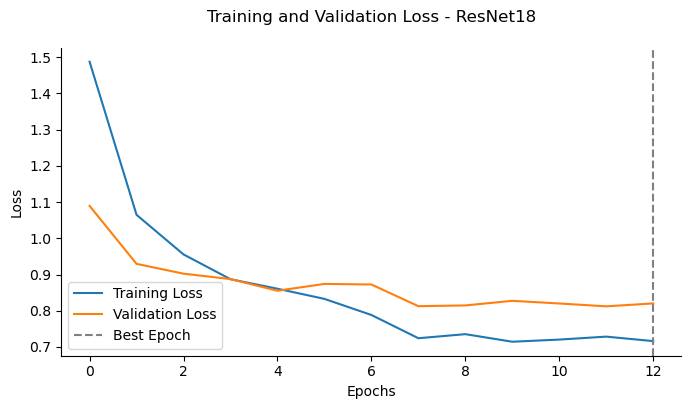

In [12]:
plot_loss(train_losses_RN18, val_losses_RN18, epoch_RN18, title="Training and Validation Loss - ResNet18\n")

As observed, the lowest loss and also best accuracy was obtained on the 12nd epoch. Using a ResNet18 as backbone for our model provided a predictive accuracy of ca. 70%. Let's take a look at these results on a confusion matrix.

P.S.: This model was run before without removing the duplicate and white images. Maybe some bias was introduced before, but a slightly higher accuracy was obtained before (73%).

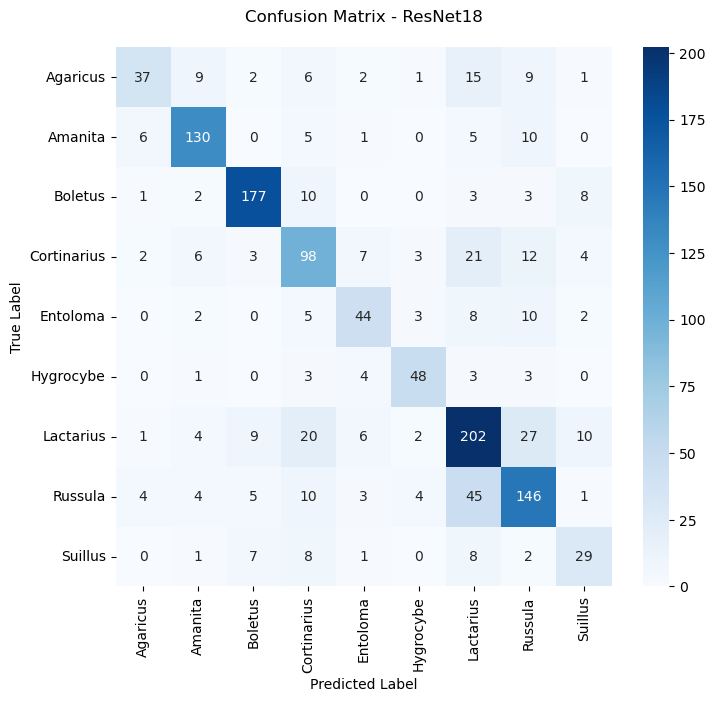

In [13]:
all_preds, all_probs, all_labels = evaluate_model(model_RN18, val_loader, device)
conf_matrix = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(conf_matrix, label_mapping, title="Confusion Matrix - ResNet18\n")

In general terms, as already described by the accuracy, most of the mushrooms are being correctly classified.

Our model however tend to wrongly classify some of the Russula and Cortinarius mushrooms in the majority class (Lactarius), and vice versa. Maybe there is some close similarity between these 3 groups, or maybe the model behaves this way because those 3 groups are majority in the dataset.

<h2 style="color:#774CAD">Model 2 - MOBILENET V2</h2>

MobileNet-v2 is a convolutional neural network that is **53 layers deep**. It is designed to be **lightweight** while maintaining **good performance**. It's suitable for scenarios where model size and inference speed are critical.

The transformation parameters of this architecture are the same as for the ResNet18, therefore will not be defined again. Our Dataset loaders are likewise defined for these transformations.

The results of the model presented here are based on the whole dataset without removal of duplicates and white images (previous status).

In [14]:
model_MNV2 = mobilenet_v2()
for param in model_MNV2.parameters():
    param.requires_grad = False

num_classes = model_MNV2.classifier[1].in_features
model_MNV2.classifier[1] = nn.Linear(num_classes, len(label_mapping))
model_MNV2 = model_MNV2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_MNV2.parameters(), lr=0.001)
step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# model_MNV2, train_losses_MNV2, val_losses_MNV2, epoch_MNV2 = train_model(
#     model_MNV2,
#     criterion,
#     optimizer,
#     step_lr_scheduler,
#     train_loader,
#     val_loader,
#     device,
#     num_epochs=25,
# )

Using a MOBILENET V2 as base model provided much worse loss (2.0 vs 0.7) and accuracy (0.26 vs 0.73) values. My first guess was that this model architecture was not trained using mushroom images, or images of natures. That however does not correspond to reality, and one of the expected label for this model is mushroom.

In [15]:
# torch.save({
#     'epoch': epoch_MNV2,
#     'model_state_dict': model_MNV2.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses_MNV2,
#     'val_losses': val_losses_MNV2
# }, 'models/mobilenetv2_model.pth')

# torch.save(model_MNV2.state_dict(), 'models/mobilenetv2_model_dict.pth')

In [16]:
model_MNV2.load_state_dict(torch.load('models/mobilenetv2_model_dict.pth'))

checkpoint = torch.load('models/mobilenetv2_model.pth')
epoch_MNV2 = checkpoint['epoch']
train_losses_MNV2 = checkpoint['train_losses']
val_losses_MNV2 = checkpoint['val_losses']

In [17]:
input_size = (3, 224, 224)
summary(model_MNV2, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

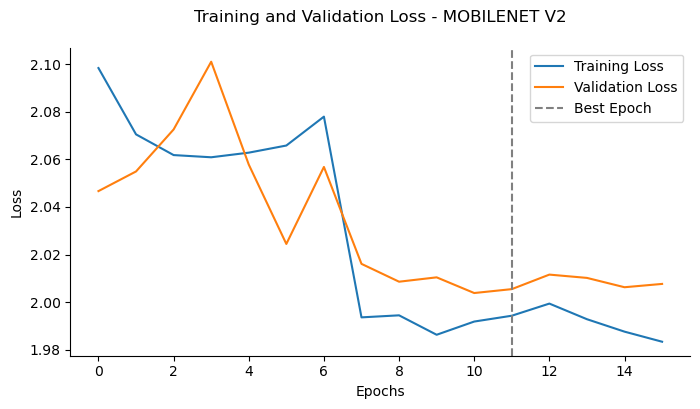

In [18]:
plot_loss(train_losses_MNV2, val_losses_MNV2, epoch_MNV2, title="Training and Validation Loss - MOBILENET V2\n")

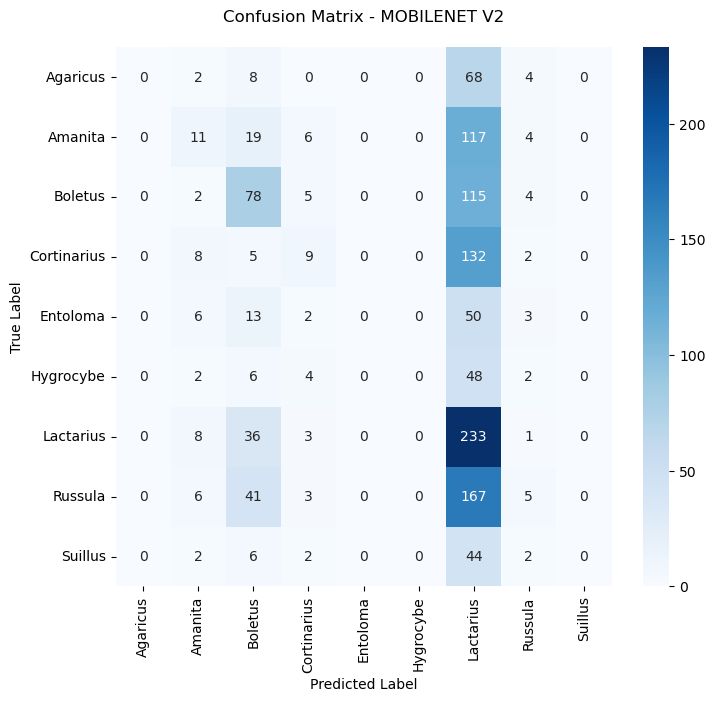

In [19]:
all_preds, all_probs, all_labels = evaluate_model(model_MNV2, val_loader, device)
conf_matrix = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(conf_matrix, label_mapping, title="Confusion Matrix - MOBILENET V2\n")

This model backbone predicts mostly mushrroms on the majority class, showing very bad prediction results.

<h2 style="color:#774CAD">Model 3 - ResNet18 with Intermediate Layer</h2>

One of the bonus challenges of this projects was to add a different layer between the backbone and the output layer. Let's see if we can get differences with this approach for our ResNet18.

The results of the model presented here are based on the whole dataset without removal of duplicates and white images (previous status).

In [20]:
backbone_model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_classes = backbone_model.fc.in_features
backbone_model.fc = nn.Identity()   # Remove fully connected

int_layer_size = 256
intermediate_layer = nn.Linear(num_classes, int_layer_size)
output_layer = nn.Linear(int_layer_size, len(label_mapping))

for param in backbone_model.parameters():
    param.requires_grad = False

model_RN18_layer = nn.Sequential(backbone_model, intermediate_layer, output_layer) # Combine new layers to backbone
print(model_RN18_layer[1])
print(model_RN18_layer[2])

Linear(in_features=512, out_features=256, bias=True)
Linear(in_features=256, out_features=9, bias=True)


In [21]:
model_RN18_layer = model_RN18_layer.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_RN18_layer.parameters(), lr=0.001)
step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# model_RN18_layer, train_losses_RN18_layer, val_losses_RN18_layer, epoch_RN18_layer = train_model(
#     model_RN18_layer,
#     criterion,
#     optimizer,
#     step_lr_scheduler,
#     train_loader,
#     val_loader,
#     device,
#     num_epochs=25,
# )

In [22]:
# torch.save({
#     'epoch': epoch_RN18_layer,
#     'model_state_dict': model_RN18_layer.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses_RN18_layer,
#     'val_losses': val_losses_RN18_layer
# }, 'models/resnet18_layer_model.pth')

# torch.save(model_RN18_layer.state_dict(), 'models/resnet18_layer_model_dict.pth')

In [23]:
model_RN18_layer.load_state_dict(torch.load('models/resnet18_layer_model_dict.pth'))

checkpoint = torch.load('models/resnet18_layer_model.pth')
epoch_RN18_layer = checkpoint['epoch']
train_losses_RN18_layer = checkpoint['train_losses']
val_losses_RN18_layer = checkpoint['val_losses']

In [24]:
input_size = (3, 224, 224)
summary(model_RN18_layer, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

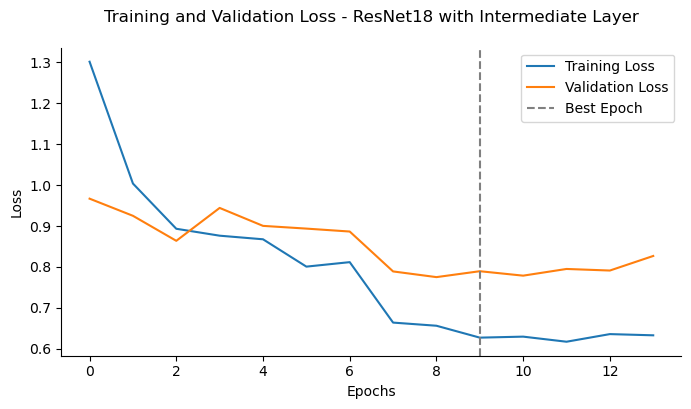

In [25]:
plot_loss(train_losses_RN18_layer, val_losses_RN18_layer, epoch_RN18_layer, title="Training and Validation Loss - ResNet18 with Intermediate Layer\n")

Taking into consideration the previous run of model 01, this approach provided us with very similar results as when only updating the fully connected layer.

I would expect, this model to suffer the same changes in case it was run on the cleaned dataset and to have a similar accuracy of around (70%).

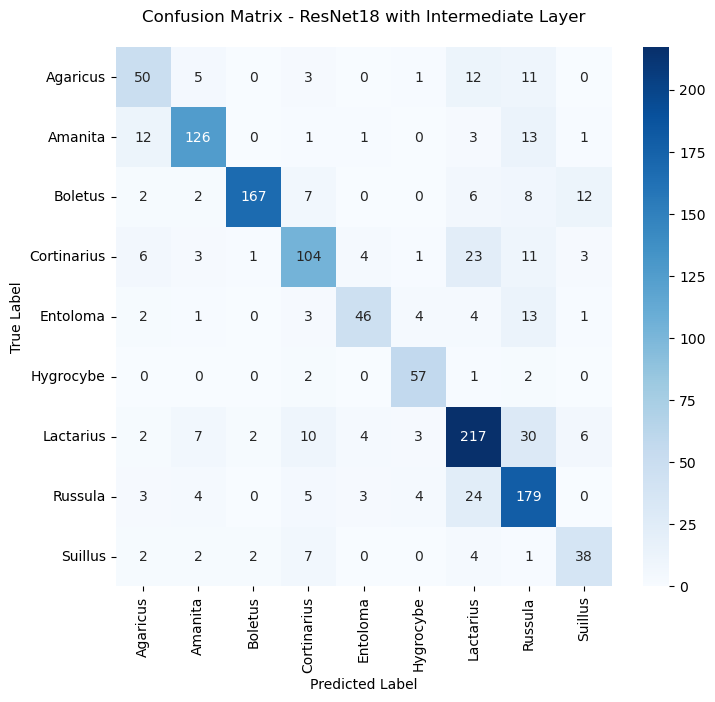

In [26]:
all_preds, all_probs, all_labels = evaluate_model(model_RN18_layer, val_loader, device)
conf_matrix = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(conf_matrix, label_mapping, title="Confusion Matrix - ResNet18 with Intermediate Layer\n")

<h1 style="color:#774CAD">Model Evaluation</h1>

After evaluation of the classification reports for both models using ResNet18, we come to the conclusion that no model is significantly better than the other (previous status of the dataset). The results are only slightly changed from one class to another. 

I decided to remove the classification report for the model with the extra layer, since it was now evaluating a dataset that possibly has some images that were used to train the model.

In [27]:
all_preds, all_probs, all_labels = evaluate_model(model_RN18, val_loader, device)
target_names = [str(label) for label in label_mapping.keys()]
report = classification_report(all_labels, all_preds, target_names=target_names, zero_division=0)
print(report)

              precision    recall  f1-score   support

    Agaricus       0.73      0.45      0.56        82
     Amanita       0.82      0.83      0.82       157
     Boletus       0.87      0.87      0.87       204
 Cortinarius       0.59      0.63      0.61       156
    Entoloma       0.65      0.59      0.62        74
   Hygrocybe       0.79      0.77      0.78        62
   Lactarius       0.65      0.72      0.68       281
     Russula       0.66      0.66      0.66       222
     Suillus       0.53      0.52      0.52        56

    accuracy                           0.70      1294
   macro avg       0.70      0.67      0.68      1294
weighted avg       0.71      0.70      0.70      1294



We can also evaluate our models in relation to the **time needed to run the test** and **quality of predictions for the test set**.

As we can see, the **accuracy is very simila**r, but the **run time for the model with an additional intermediate layer is a bit longer**.

In [29]:
all_preds, all_probs, all_labels, test_accuracy, average_test_loss = evaluate_model_on_test(model_RN18, criterion, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Average Test Loss: {average_test_loss:.4f}')


Test run in 0m 31s
Test Accuracy: 0.7303
Average Test Loss: 0.7435


In [30]:
all_preds, all_probs, all_labels, test_accuracy, average_test_loss = evaluate_model_on_test(model_RN18_layer, criterion, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Average Test Loss: {average_test_loss:.4f}')


Test run in 0m 30s
Test Accuracy: 0.7661
Average Test Loss: 0.6272


There was before a considerable difference in the running time for both models. 30s (ResNet18) to 45s (ResNet18 extra layer).

In this last try, both models ran in similar time (could this be because of the previous reasons of images from training in validation?).

However, even the previous difference in time could potentially not be enough to justify the first model as being better. We will use Model 1 for the next section and let's show now some random images and the classification given to each of them in the test set.

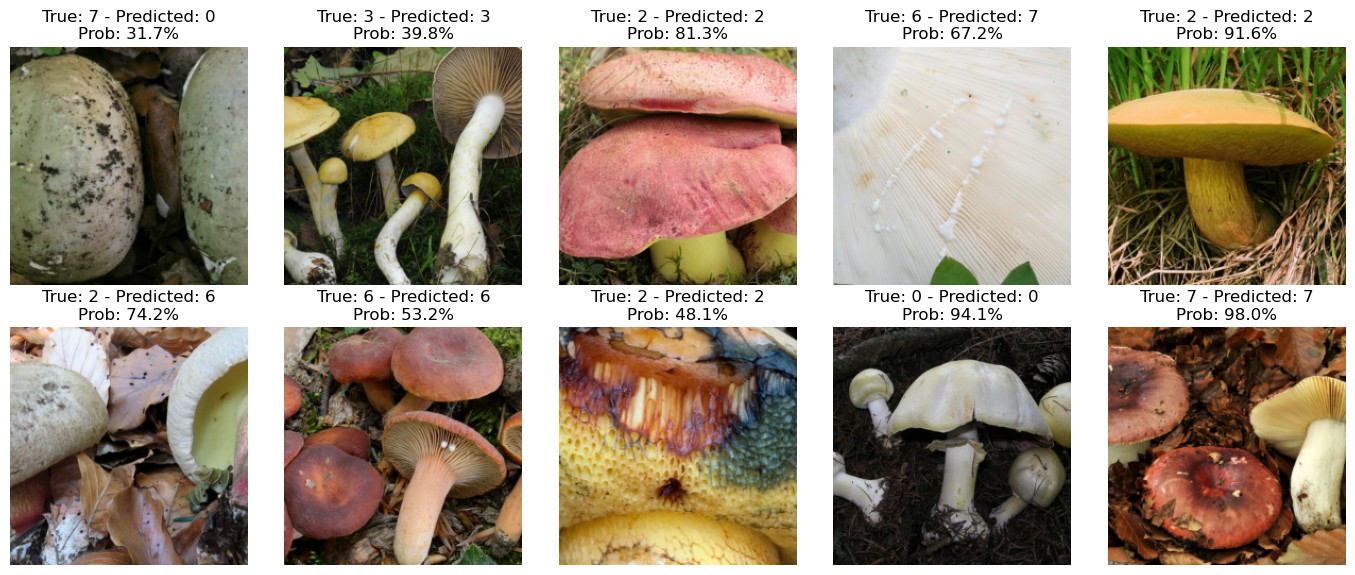

In [31]:
import random

sample_indices = random.sample(range(len(all_labels)), 10)
fig, axs = plt.subplots(2, 5, figsize=(14, 6))
axs = axs.flatten()

for i, idx in enumerate(sample_indices):
    ax = axs[i]
    image, true_label = test_loader.dataset[idx]

    inverse_transform = transforms.Compose([
        transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std]),
        transforms.ToPILImage()
    ]) #invert transform and convert to image

    predicted_label = all_preds[idx]
    probability = max(all_probs[idx]) *100

    ax.imshow(inverse_transform(image))
    ax.axis('off')
    ax.set_title(f'True: {true_label} - Predicted: {predicted_label}\nProb: {probability:.1f}%')

plt.tight_layout(pad=2)


<h2 style="color:#774CAD">Classification of my Personal Archive</h2>

Just as an extra part of this work, I got 4 of my personal mushroom pictures to evaluate in the model. I checked which group they belong to through google lens. After the first evaluation, I included a copy of image 03 zoomed, to check if results would change.

01-Amanita Muscaria</br>
02-Russula Luteotacta</br>
03-Amanita Virosa</br>
03_copy-Amanita Virosa</br>
04_Lactarius Badiosangineus</br>

In [32]:
def read_images(image_paths):
    images_raw = []
    for path in image_paths:
        img = Image.open(path)
        images_raw.append(img)
    return images_raw

random_rows = images_df.groupby("label").sample(1)
images = pd.DataFrame({"images": read_images(random_rows["path"])})
images["label"] = [title for title in set(images_df["label"])]

In [33]:
img_paths = [os.path.join("personal_images", f) for f in os.listdir("personal_images") if f.lower().startswith('0')]
img_labels = ['Amanita', 'Russula', 'Amanita', 'Amanita', 'Lactarius']
personal_df = pd.DataFrame({"path": img_paths,"label": img_labels})
personal_df["images"] = pd.DataFrame({"images": read_images(personal_df["path"])})
personal_df

,path,label,images
0,personal_images\01.jpg,Amanita,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,personal_images\02.jpg,Russula,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,personal_images\03.jpg,Amanita,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,personal_images\03_copy.jpg,Amanita,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,personal_images\04.jpg,Lactarius,<PIL.JpegImagePlugin.JpegImageFile image mode=...


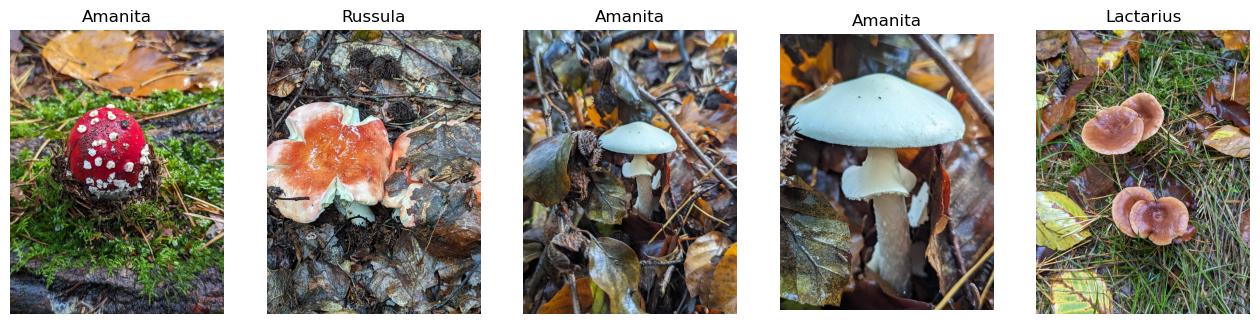

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
axs = axs.flatten()

for ax, (img, label) in zip(axs, zip(personal_df["images"], personal_df["label"])):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(label, fontsize=12, y=1)

Let's apply our transformers and evaluate these images.

In [35]:
eval_images = [transform(Image.open(img_path)) for img_path in personal_df["path"]]

In [36]:
with torch.no_grad():
    model_RN18.eval()
    inputs = torch.stack(eval_images)
    outputs = model_RN18(inputs)

_, preds = torch.max(outputs, 1)
probs = nn.functional.softmax(outputs, dim=1)

In [37]:
probs_array = np.round(probs.cpu().numpy(), 4)
probs_df = pd.DataFrame({'probabilities': [a for a in probs_array]})

personal_df['predicted_label'] = preds.cpu().numpy()
personal_df = pd.concat([personal_df, probs_df], axis=1)

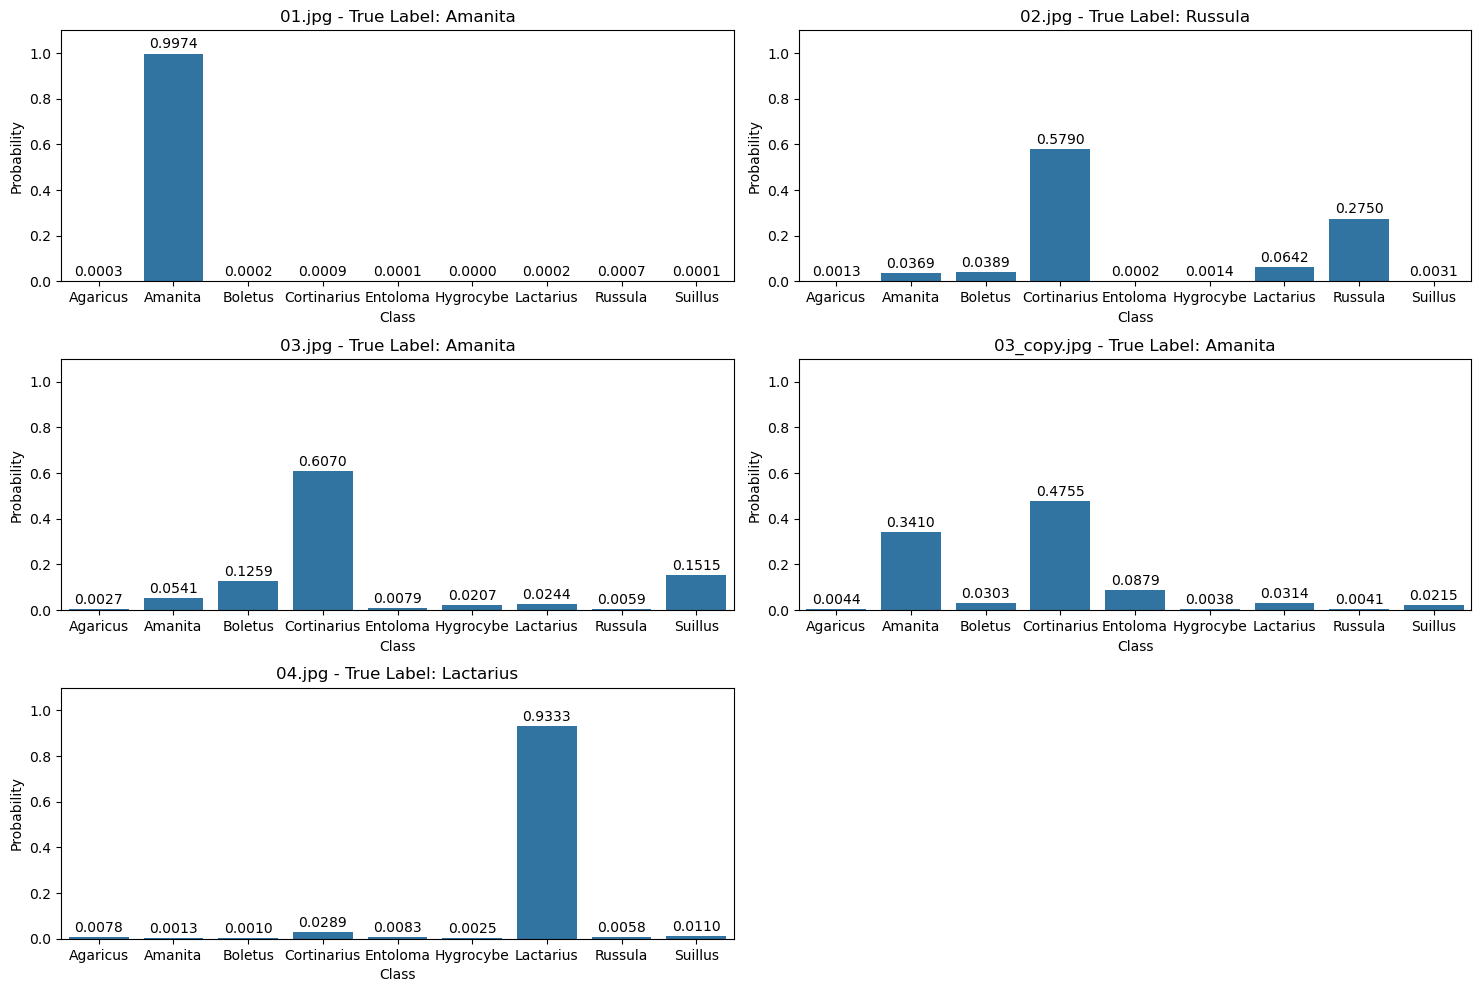

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()

for i, (_, row) in enumerate(personal_df.iterrows()):
    labels = label_mapping.keys()  # Assuming label_mapping contains your class labels
    probabilities = row['probabilities']
    _, filename = os.path.split(row['path'])

    sns.barplot(x=list(labels), y=probabilities, ax=axs[i])
    axs[i].set_title(f"{filename} - True Label: {row['label']}")
    axs[i].set_xlabel("Class")
    axs[i].set_ylabel("Probability")
    axs[i].set_ylim([0, 1.1])

    for bar, prob in zip(axs[i].patches, probabilities):
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{prob:.4f}', ha='center', va='bottom')

plt.tight_layout(pad=1)
plt.delaxes(axs[-1])

For my 4 personal mushroom pictures, the model classifies correctly 2 with above 93% of confidency.

For image 02, the model only recognizes that this is a Russula by 27%, placing by 58% this mushroom as Cortinarius.

Image 03, was also wrongly missplaced as Cortinarius (60%), and as Amanita only by 5%. The submitted zoomed Image 03, however presented a much higher likeability of being Amanita (34%), Cortinarius went down to 47%, highlighting that these models are still not able to understand what parts of the pictures are the most important, and a zoom can drastically improve the model results.

<h1 style="color:#774CAD">Conclusions</h1>

In this project we leveraged the power of convolutional neural networks to classify mushrooms genuses. Our models using as backbone the archtecture ResNet18 obtained a classification accuracy of about 70%.

The implementation of an extra layer, did not seem to change the model results. Also a model try using MOBILENET V2 provided bad results, classifying most of the mushrooms in the majority group.

We proved through the analysis of some personal mushroom photos that zooming close to a mushroom can increase the classification power of the model.

**Improvements:**
- Evaluate the quality of the split and if proportions in each dataset are roughly kept the same.
- Due to the absence of better computational resources:
    - I did not run my model with other adapters.
    - I did not try other models as backbones, specially more complex ones like ResNet50 /101 and so on.
- Implement class weight balance for the model train and check improvements/worsening in the results.
- Explore more ways to evaluate the model (I am very open to suggestions).